In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


import sklearn
from sklearn.linear_model import LogisticRegression, LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from sklearn.neighbors import KNeighborsRegressor

from tqdm import tqdm
import yaml

In [2]:
with open('edlMap2.yaml', 'r') as file:
    config = yaml.safe_load(file)

origin = config['origin']

res = config['resolution']

mapData = plt.imread("edlMapEdit.pgm")

Ny, Nx = np.shape(mapData)

In [3]:
train_dataset = loadmat("edlData.mat")['dataset'].astype(float)

In [4]:
test_dataset = loadmat("edlDataTest.mat")['dataset'].astype(float)

In [5]:
train_dataset.shape

(2434, 1097)

In [6]:
test_dataset.shape

(1140, 1097)

In [7]:
dummy_data = train_dataset[:, 1:]
pf_pose = dummy_data[:, 0:4]

lidar_data = dummy_data[:, 4:1085]
# lidar_data[lidar_data > 10] = 0

odom_data = dummy_data[:, 1085:1091]

imu_data = dummy_data[:, 1091:]

imu_data[:, [1, 0]] = imu_data[:, [0, 1]]

imu_accel_factor = 9.198166819431714

imu_gyro_factor = 1/25714

imu_data[:, :2] *= imu_accel_factor

imu_data[:, 2] *= imu_gyro_factor

In [8]:
train_dataset = np.hstack([pf_pose, lidar_data, odom_data, imu_data])
train_dataset.shape

(2434, 1096)

In [9]:
dummy_data = test_dataset[:, 1:]
pf_pose = dummy_data[:, 0:4]

lidar_data = dummy_data[:, 4:1085]

# lidar_data[lidar_data > 10] = 0

odom_data = dummy_data[:, 1085:1091]

imu_data = dummy_data[:, 1091:]

imu_data[:, [1, 0]] = imu_data[:, [0, 1]]

imu_accel_factor = 9.198166819431714

imu_gyro_factor = 1/25714

imu_data[:, :2] *= imu_accel_factor

imu_data[:, 2] *= imu_gyro_factor

In [10]:
test_dataset = np.hstack([pf_pose, lidar_data, odom_data, imu_data])
test_dataset.shape

(1140, 1096)

In [62]:
mean = np.mean(train_dataset[:, 2:], axis=0)
std_dev = np.std(train_dataset[:, 2:], axis=0)
train_dataset[:, 2:] = (train_dataset[:, 2:] - mean)/std_dev
test_dataset[:, 2:] = (test_dataset[:, 2:] - mean)/std_dev

class Custom_Data_Loader(Dataset):

    def __init__(self, data):

        self.labels = data[:,:2]
        self.features = data[:,2:]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        positions = torch.tensor(self.labels[idx,:])
        features = torch.tensor(self.features[idx,:])

        return (positions, features)

In [63]:
training_data = Custom_Data_Loader(train_dataset)
testing_data = Custom_Data_Loader(test_dataset)

In [64]:
train_loader =  DataLoader(training_data, batch_size = 32, shuffle = True, num_workers = 2)
test_loader =  DataLoader(testing_data, batch_size = 32, shuffle = False, num_workers = 2)

In [88]:


class Pos_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1094, 1024)
        self.linear2 = nn.Linear(1024, 512) 
        self.linear3 = nn.Linear(512, 64)
        self.linear4 = nn.Linear(64, 16)
        self.linear5 = nn.Linear(16, 2)
        
        # self.act = nn.GELU()
        self.act = nn.Sigmoid()
        self.double()

    def forward(self, x):

        x = self.linear1(x)
        x = self.act(x)
        x = self.linear2(x)
        x = self.act(x)
        x = self.linear3(x)
        x = self.act(x)
        x = self.linear4(x)
        x = self.act(x)
        x = self.linear5(x)

        return x

In [89]:
model = Pos_Model()
model.cuda()

Pos_Model(
  (linear1): Linear(in_features=1094, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=16, bias=True)
  (linear5): Linear(in_features=16, out_features=2, bias=True)
  (act): Sigmoid()
)

In [90]:
epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0007)
criterion = torch.nn.MSELoss()

EPOCH:  0
###### TRAINING #########
Training_Loss:  3.377069687756914
###### TESTING #########
Testing_Loss:  3.399042383740535


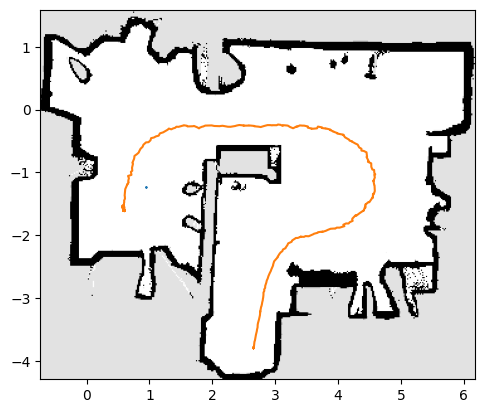

EPOCH:  1
###### TRAINING #########
Training_Loss:  2.001477604412097
###### TESTING #########
Testing_Loss:  2.1949703790497903


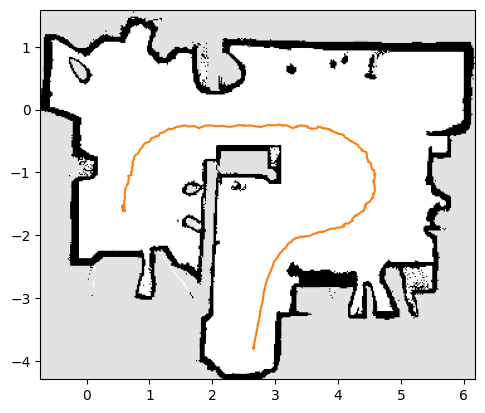

EPOCH:  2
###### TRAINING #########
Training_Loss:  1.6066241154408465
###### TESTING #########
Testing_Loss:  1.7552065020623315


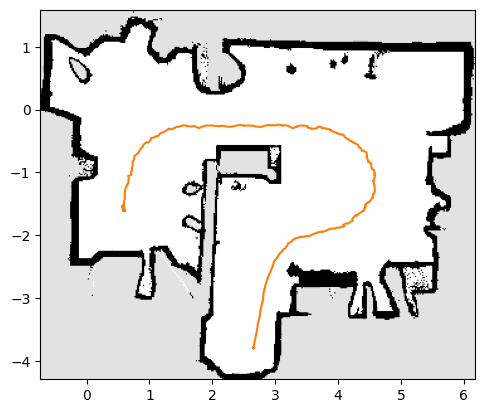

EPOCH:  3
###### TRAINING #########
Training_Loss:  1.487379836776249
###### TESTING #########
Testing_Loss:  1.509067079948341


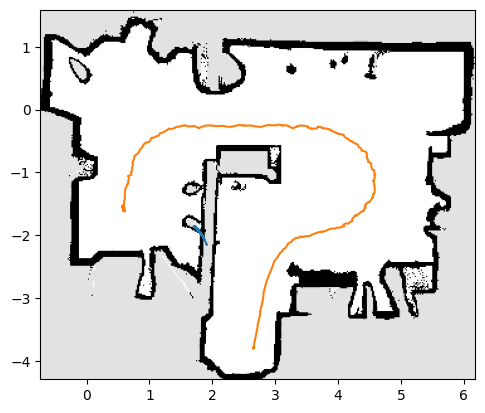

EPOCH:  4
###### TRAINING #########
Training_Loss:  0.9309356810092806
###### TESTING #########
Testing_Loss:  0.8343628157721209


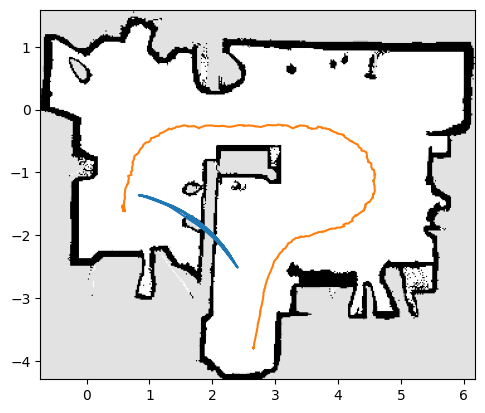

EPOCH:  5
###### TRAINING #########
Training_Loss:  0.6217604912926114
###### TESTING #########
Testing_Loss:  0.6054366317163159


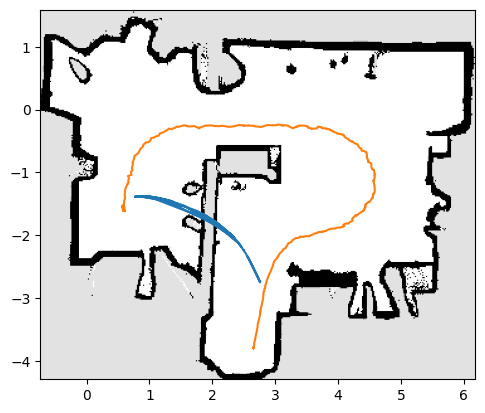

EPOCH:  6
###### TRAINING #########
Training_Loss:  0.4770710980295632
###### TESTING #########
Testing_Loss:  0.5077366441260033


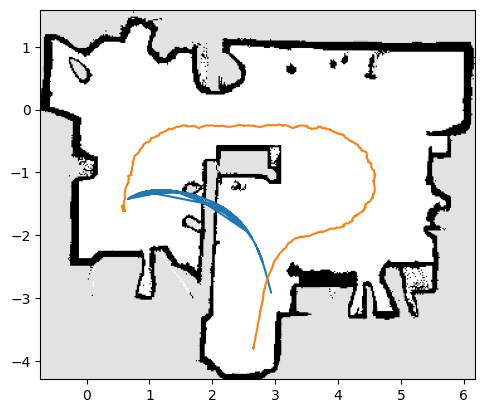

EPOCH:  7
###### TRAINING #########
Training_Loss:  0.35907593248210257
###### TESTING #########
Testing_Loss:  0.38230951424950244


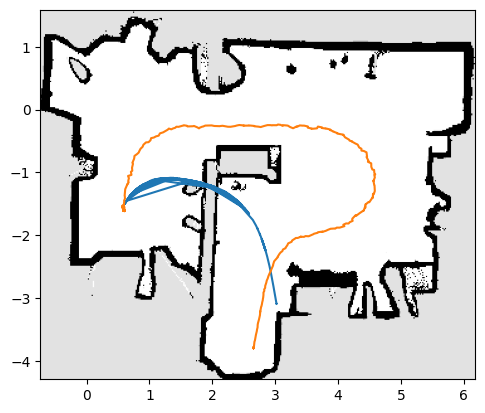

EPOCH:  8
###### TRAINING #########
Training_Loss:  0.2867944207799754
###### TESTING #########
Testing_Loss:  0.2936289578666783


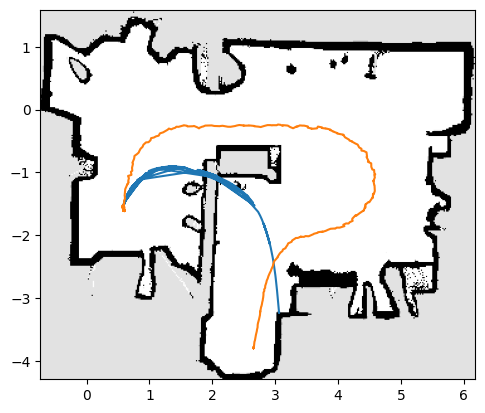

EPOCH:  9
###### TRAINING #########
Training_Loss:  0.23260116749065682
###### TESTING #########
Testing_Loss:  0.25268656665836897


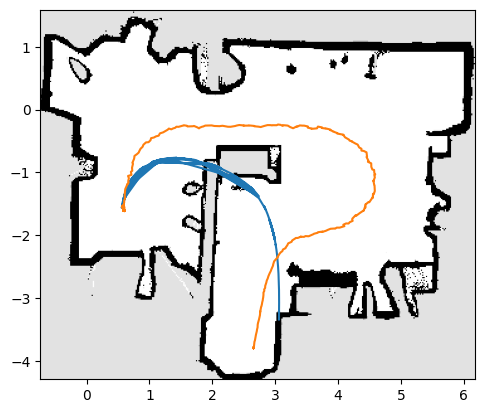

EPOCH:  10
###### TRAINING #########
Training_Loss:  0.19192520679032124
###### TESTING #########
Testing_Loss:  0.1992819778239926


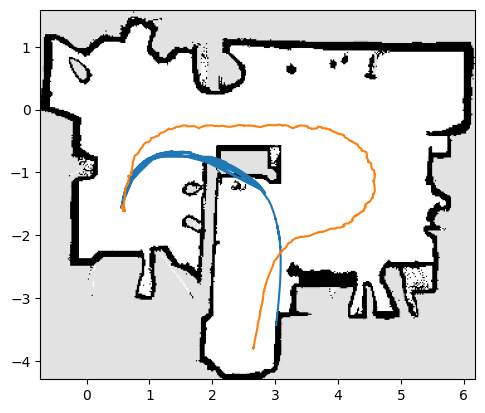

EPOCH:  11
###### TRAINING #########
Training_Loss:  0.15438069874209506
###### TESTING #########
Testing_Loss:  0.1533380114307427


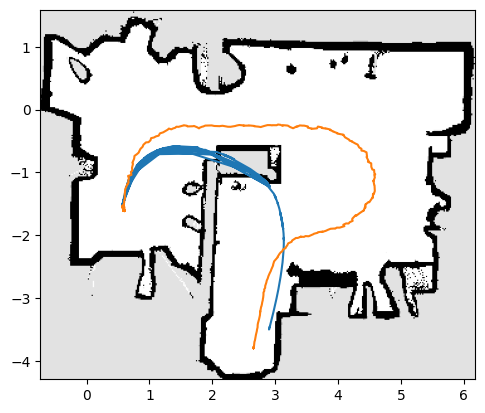

EPOCH:  12
###### TRAINING #########
Training_Loss:  0.12162739633136746
###### TESTING #########
Testing_Loss:  0.13236956180180176


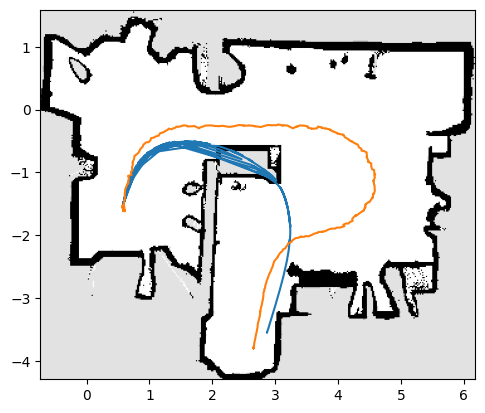

EPOCH:  13
###### TRAINING #########
Training_Loss:  0.0963481042895181
###### TESTING #########
Testing_Loss:  0.09769730123824


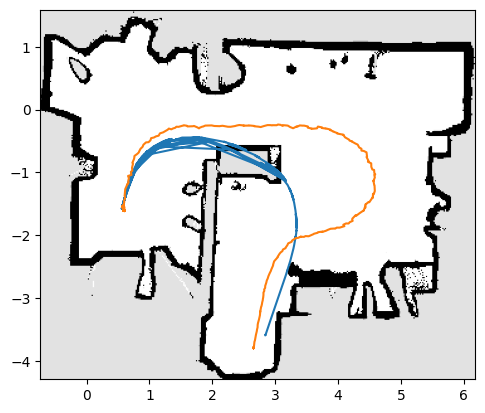

EPOCH:  14
###### TRAINING #########
Training_Loss:  0.0776201945060791
###### TESTING #########
Testing_Loss:  0.08899910569051797


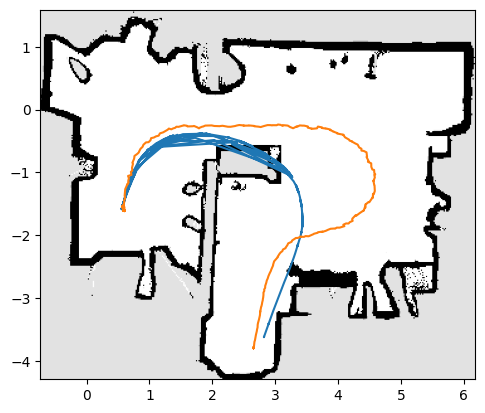

EPOCH:  15
###### TRAINING #########
Training_Loss:  0.06387306680996244
###### TESTING #########
Testing_Loss:  0.0752758953143287


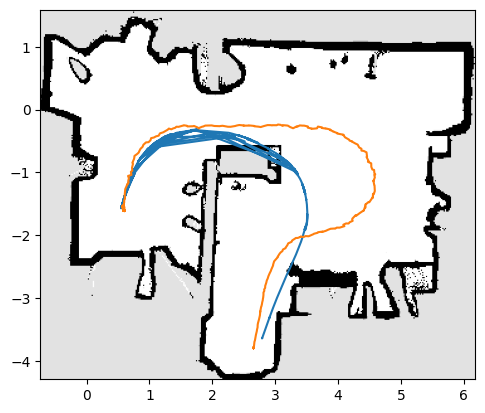

EPOCH:  16
###### TRAINING #########
Training_Loss:  0.0563426673488173
###### TESTING #########
Testing_Loss:  0.06719012057861068


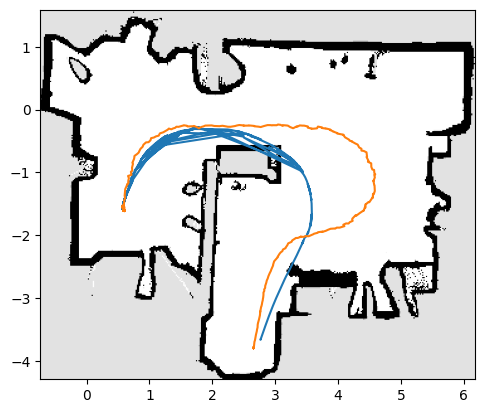

EPOCH:  17
###### TRAINING #########
Training_Loss:  0.04368124723166568
###### TESTING #########
Testing_Loss:  0.05920070967748118


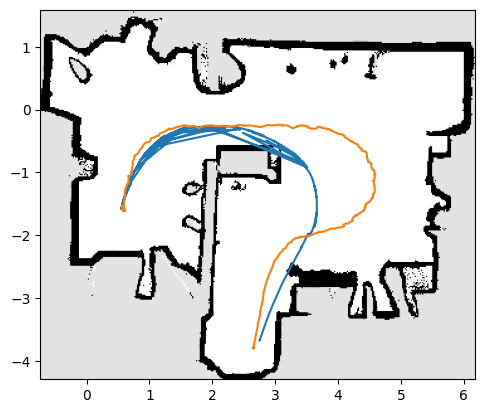

EPOCH:  18
###### TRAINING #########
Training_Loss:  0.03846597343980644
###### TESTING #########
Testing_Loss:  0.0557994510248488


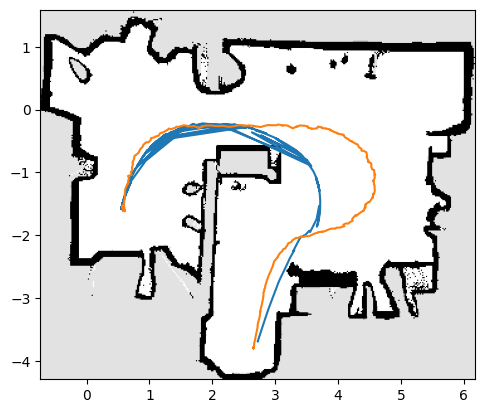

EPOCH:  19
###### TRAINING #########
Training_Loss:  0.02975567231886091
###### TESTING #########
Testing_Loss:  0.049284475330303605


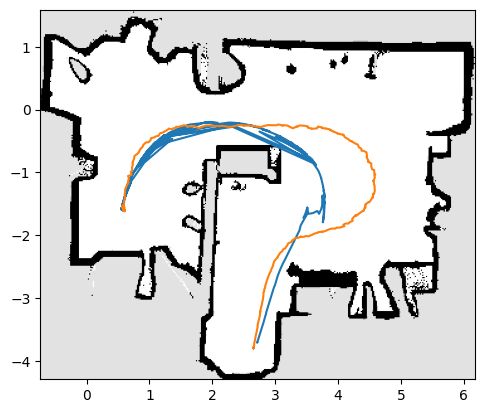

In [91]:
for epoch in range(epochs):
  print('EPOCH: ', epoch)
  print('###### TRAINING #########')
  running_loss = 0
  for i, data in enumerate(train_loader):

      model.train()

      gt, features = data


      gt = gt.cuda()
      features = features.cuda()

      # print(type(features))

      optimizer.zero_grad()

      out = model(features)
      # print(out)

      loss = criterion(out, gt)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

  loss = running_loss/(len(train_loader))

  print('Training_Loss: ', loss)


  print('###### TESTING #########')

  out_path = []
  running_loss = 0
  for i, data in enumerate(test_loader):

      model.eval()

      gt, features = data
      gt = gt.cuda()
      features = features.cuda()

      with torch.no_grad():
          out = model(features)
      out_path.append(out)
      loss = criterion(out, gt)

      running_loss += loss.item()

  loss = running_loss/(len(test_loader))
  print('Testing_Loss: ', loss)
  out_path = torch.cat(out_path)
  out_path = np.array(out_path.detach().cpu())
  plt.plot(out_path[:,0], out_path[:,1])
  plt.plot(test_dataset[:,0], test_dataset[:,1])
  plt.imshow(mapData, extent=[origin[0], origin[0] + Nx*res, origin[1], origin[1] + Ny*res], cmap  = 'Greys_r')
  plt.show()

